## Implementation of Elementary Reinforcement Learning from RL Course by David Silver.

In [1]:
import numpy as np
import gym
from tqdm import tqdm
from time import sleep
import pickle
import random
import matplotlib.pyplot as plt
import tensorflow as tf

/Users/odats/openai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env = gym.make('FrozenLake-v0')
s0 = env.reset()
env.render()
# when you make action there is 33% chance to get to another space
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3


SFFF
FHFH
FFFH
HFFG


### Exploration vs Exploitation

In [3]:
def e_greedy_policy(q_table, state, env, epsilon = 0.25):
    if random.random() < epsilon:
        action = env.action_space.sample()     
    else:
        action = np.argmax(q_table[state,:])
        
    return action

def e_greedy_policy_decay(q_table, state, k, number_of_runs, env):
    epsilon = 1 - (k/number_of_runs)
    
    actions_count = env.action_space.n
    act_greedy = epsilon / actions_count + (1 - epsilon)
    
    if random.random() < act_greedy:
        action = np.argmax(q_table[state,:])
    else:
        action = env.action_space.sample()
        
    return action

def ucb_policy(q_table, state, q_table_n, k, number_of_runs, env):
    action = np.argmax(np.add(q_table[state,:], 2*(np.log(k) / q_table_n[state,:])))
    
    return action

def random_policy(q_table, state, env):
    action = env.action_space.sample()
    return action

def greedy_policy(q_table, state):
    action = np.argmax(q_table[state,:])
    return action

In [21]:
def one_hot_encoding(item, size=1):
    one_hot = np.zeros(size)
    one_hot[item]=1
    
    return one_hot

### Evaluate policy

In [4]:
def evaluate_policy(env, q_table, max_episodes=1000): 
    tot_reward = 0
    for ep in range(max_episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        
        # Reward per episode
        while not done:
            action = greedy_policy(q_table, state)
            new_state, reward, done, _ = env.step(action)
            ep_reward += reward
            state = new_state
            if done:
                tot_reward += ep_reward
                
    return tot_reward / max_episodes

### Monte-Carlo

In [5]:
def monte_carlo_train(env, number_of_runs=10000, gama=0.9, use_e_greedy_policy_decay=False,
                      MC_first_occurrence=False, use_trace_of_learning=True):
    
    state_values = np.zeros(env.observation_space.n)
    n_of_s = np.zeros(env.observation_space.n)

    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    #q_table = np.random.random((env.observation_space.n, env.action_space.n))
    q_table_n = np.zeros((env.observation_space.n, env.action_space.n))

    trace_of_learning = []
    trace_of_won = []
    won_count = 0
    for k in tqdm(range(1, number_of_runs)):
        trajectory_states = []
        trajectory_actions = []
        trajectory_rewards = []
        trajectory_total_discounted_rewards = []

        current_state = env.reset()
        done = False
        while not done: 
            if use_e_greedy_policy_decay:
                action = e_greedy_policy_decay(q_table, current_state, k, number_of_runs, env)
                #action = ucb_policy(q_table, current_state, q_table_n, k, number_of_runs, env)
            else:
                action = e_greedy_policy(q_table, current_state, env)
            
            new_state, reward, done, prob = env.step(action)

            trajectory_states.append(current_state)
            trajectory_actions.append(action)
            trajectory_rewards.append(reward)

            current_state = new_state

        for idx_state, state in enumerate(trajectory_states):
            total_discounted_reward = 0
            for idx_reward, reward in enumerate(trajectory_rewards[idx_state:]):
                total_discounted_reward += reward * (gama**idx_reward)
            trajectory_total_discounted_rewards.append(total_discounted_reward)
            
        # fill action states values
        q_table_n_first = np.zeros((env.observation_space.n, env.action_space.n))
        for step in range(len(trajectory_states)):
            step_state = trajectory_states[step]
            step_action = trajectory_actions[step]
            
            # MC first occurrence
            if MC_first_occurrence:
                if q_table_n_first[step_state][step_action] != 0:
                    continue
                q_table_n_first[step_state][step_action] = 1
            
            q_table_n[step_state][step_action] += 1
            n = q_table_n[step_state][step_action]

            current_value = q_table[step_state][step_action]
            alfa = (1/n)
            new_value = current_value + alfa * (trajectory_total_discounted_rewards[step] - current_value)
            q_table[step_state][step_action] = new_value

        # fill states values
        for step, state in enumerate(trajectory_states):
            n_of_s[state] += 1 
            state_values[state] = state_values[state] + (1/n_of_s[state]) * (trajectory_total_discounted_rewards[step]-state_values[state])
            
        # trace log   
        if reward == 1:
            won_count += 1
        if use_trace_of_learning and k%1000 == 0:
            trace_of_learning.append(evaluate_policy(env, q_table))
            trace_of_won.append(won_count)
            won_count = 0
        
    return q_table, trace_of_learning, trace_of_won
    

### Temporal difference SARSA

In [6]:
def sarsa_train(env, number_of_runs=10000, alfa=0.5, gama=0.9,
                use_e_greedy_policy_decay=False, use_trace_of_learning=True):
    
    q_table = np.zeros((env.observation_space.n, env.action_space.n))

    trace_of_learning = []
    trace_of_won = []
    won_count = 0
    for k in tqdm(range(1, number_of_runs)):
        current_state = env.reset()
        if use_e_greedy_policy_decay:
            current_action = e_greedy_policy_decay(q_table, current_state, k, number_of_runs, env)
        else:
            current_action = e_greedy_policy(q_table, current_state, env)
            
        done = False
        while not done: 
            new_state, reward, done, prob = env.step(current_action)
            if use_e_greedy_policy_decay:
                new_action = e_greedy_policy_decay(q_table, new_state, k, number_of_runs, env)
            else:
                new_action = e_greedy_policy(q_table, new_state, env)
            
            q_table[current_state][current_action] += alfa*(reward + gama* q_table[new_state][new_action] - q_table[current_state][current_action])

            current_state = new_state
            current_action = new_action
      
        # trace log   
        if reward == 1:
            won_count += 1
        if use_trace_of_learning and k%1000 == 0:
            trace_of_learning.append(evaluate_policy(env, q_table))
            trace_of_won.append(won_count)
            won_count = 0
        
    return q_table, trace_of_learning, trace_of_won

### Q-learning. SARSA off model. 

In [7]:
def q_learning_train(env, number_of_runs=10000, alfa=0.5, gama=0.9, 
                     use_e_greedy_policy_decay=False, use_trace_of_learning=True):
    
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    
    trace_of_learning = []
    trace_of_won = []
    won_count = 0
    for k in tqdm(range(1, number_of_runs)):
        current_state = env.reset()
        done = False
        while not done: 
            if use_e_greedy_policy_decay:
                current_action = e_greedy_policy_decay(q_table, current_state, k, number_of_runs, env)
            else:
                current_action = e_greedy_policy(q_table, current_state, env)
            new_state, reward, done, prob = env.step(current_action)
                    
            target_action = greedy_policy(q_table, new_state)
            
            q_table[current_state][current_action] += alfa*(reward + gama* q_table[new_state][target_action] - q_table[current_state][current_action])

            current_state = new_state
      
        # trace log   
        if reward == 1:
            won_count += 1
        if use_trace_of_learning and k%1000 == 0:
            trace_of_learning.append(evaluate_policy(env, q_table))
            trace_of_won.append(won_count)
            won_count = 0
        
    return q_table, trace_of_learning, trace_of_won

### Value function approximation

In [35]:
def vf_tf_monte_carlo_train(env, number_of_runs=10000, gama=0.9, use_e_greedy_policy_decay=False,
                      MC_first_occurrence=False, use_trace_of_learning=True):
    
    # ------------------------------------------------------------
    tf.reset_default_graph()
    #These lines establish the feed-forward part of the network used to choose actions
    input_state = tf.placeholder(shape=[1,16], dtype=tf.float32)
    W = tf.Variable(tf.random_uniform([16,4],0,0.01))
    predicted_q_values = tf.matmul(input_state, W)
    predicted_action = tf.argmax(predicted_q_values, 1)

    #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
    real_q_values = tf.placeholder(shape=[1,4], dtype=tf.float32)
    loss = tf.reduce_sum(tf.square(real_q_values - predicted_q_values))
    trainer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    update_model = trainer.minimize(loss)
    
    # start
    init = tf.global_variables_initializer()
    # ------------------------------------------------------------

    trace_of_learning = []
    trace_of_won = []
    won_count = 0
    with tf.Session() as sess:
        sess.run(init)
        
        for k in tqdm(range(1, number_of_runs)):
            trajectory_states = []
            trajectory_actions = []
            trajectory_rewards = []
            trajectory_total_discounted_rewards = []

            current_state = env.reset()
            done = False
            while not done: 
                a, q_table = sess.run([predicted_action, predicted_q_values], 
                                      feed_dict={input_state:[one_hot_encoding(current_state, 16)]})
                action = a[0]
                if use_e_greedy_policy_decay:
                    action = e_greedy_policy_decay(q_table, 0, k, number_of_runs, env)
                    #action = ucb_policy(q_table, current_state, q_table_n, k, number_of_runs, env)
                else:
                    action = e_greedy_policy(q_table, 0, env)

                new_state, reward, done, prob = env.step(action)

                trajectory_states.append(current_state)
                trajectory_actions.append(action)
                trajectory_rewards.append(reward)

                current_state = new_state

            for idx_state, state in enumerate(trajectory_states):
                total_discounted_reward = 0
                for idx_reward, reward in enumerate(trajectory_rewards[idx_state:]):
                    total_discounted_reward += reward * (gama**idx_reward)
                trajectory_total_discounted_rewards.append(total_discounted_reward)

            # learning
            # w ← w + α[Gt − vˆ(St,w)] ∇vˆ(St,w)
            for step in range(len(trajectory_states)):
                step_state = trajectory_states[step]
                step_action = trajectory_actions[step]
                Gt = trajectory_total_discounted_rewards[step]
                estimated_q_table = sess.run(predicted_q_values, 
                                             feed_dict={input_state:[one_hot_encoding(step_state, 16)]})
                # make stimated values real
                estimated_q_table[0, step_action] = Gt

                #Train our network using target and predicted Q values
                _,W1 = sess.run([update_model, W],
                                feed_dict={input_state:[one_hot_encoding(step_state, 16)], real_q_values:estimated_q_table})

            # trace log   
            if reward == 1:
                won_count += 1
            if use_trace_of_learning and k%1000 == 0:
                trace_of_won.append(won_count)
                won_count = 0
        
        q_table_final = np.zeros((env.observation_space.n, env.action_space.n))
        for current_state in range(16):
            a, q_table = sess.run([predicted_action, predicted_q_values], 
                                      feed_dict={input_state:[one_hot_encoding(current_state, 16)]})
                
            q_table_final[current_state] = q_table
        print(q_table_final)
    
    return W, trace_of_learning, trace_of_won

In [41]:
def vf_tf_sarsa_train(env, number_of_runs=10000, alfa=0.5, gama=0.9,
                use_e_greedy_policy_decay=False, use_trace_of_learning=True):
    
    # ------------------------------------------------------------
    tf.reset_default_graph()
    #These lines establish the feed-forward part of the network used to choose actions
    input_state = tf.placeholder(shape=[1,16], dtype=tf.float32)
    W = tf.Variable(tf.random_uniform([16,4],0,0.01))
    predicted_q_values = tf.matmul(input_state, W)
    predicted_action = tf.argmax(predicted_q_values, 1)

    #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
    real_q_values = tf.placeholder(shape=[1,4], dtype=tf.float32)
    loss = tf.reduce_sum(tf.square(real_q_values - predicted_q_values))
    trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
    update_model = trainer.minimize(loss)
    
    # start
    init = tf.global_variables_initializer()
    # ------------------------------------------------------------

    trace_of_learning = []
    trace_of_won = []
    won_count = 0
    with tf.Session() as sess:
        sess.run(init)
        for k in tqdm(range(1, number_of_runs)):
            current_state = env.reset()
            a, q_table = sess.run([predicted_action, predicted_q_values], 
                                          feed_dict={input_state:[one_hot_encoding(current_state, 16)]})
            current_action = a[0]
            if use_e_greedy_policy_decay:
                current_action = e_greedy_policy_decay(q_table, 0, k, number_of_runs, env)
            else:
                current_action = e_greedy_policy(q_table, 0, env)

            done = False
            while not done: 
                a, q_table = sess.run([predicted_action, predicted_q_values], 
                                          feed_dict={input_state:[one_hot_encoding(current_state, 16)]})

                new_state, reward, done, prob = env.step(current_action)

                a, q_table_new = sess.run([predicted_action, predicted_q_values], 
                                          feed_dict={input_state:[one_hot_encoding(new_state, 16)]})

                if use_e_greedy_policy_decay:
                    new_action = e_greedy_policy_decay(q_table_new, 0, k, number_of_runs, env)
                else:
                    new_action = e_greedy_policy(q_table_new, 0, env)


                # make stimated values real
                q_table[0, current_action] = reward + gama* q_table_new[0][new_action]

                _,W1 = sess.run([update_model, W],
                                    feed_dict={input_state:[one_hot_encoding(current_state, 16)], real_q_values:q_table})

                current_state = new_state
                current_action = new_action

            # trace log   
            if reward == 1:
                won_count += 1
            if use_trace_of_learning and k%1000 == 0:
                trace_of_won.append(won_count)
                won_count = 0
        
        q_table_final = np.zeros((env.observation_space.n, env.action_space.n))
        for current_state in range(16):
            a, q_table = sess.run([predicted_action, predicted_q_values], 
                                      feed_dict={input_state:[one_hot_encoding(current_state, 16)]})

            q_table_final[current_state] = q_table
        print(q_table_final)
    
    return W, trace_of_learning, trace_of_won

### Gradient based on numpy

In [9]:
def q_table_approximation(W, state, env):
    # forward propagetion
    qa1 = np.dot(W, prepare_x(state, 0))
    qa2 = np.dot(W, prepare_x(state, 1))
    qa3 = np.dot(W, prepare_x(state, 2))
    qa4 = np.dot(W, prepare_x(state, 3))
    
    q_table = np.array([[qa1, qa2, qa3, qa4]])
    
    return q_table

def evaluate_nn_policy(env, W, max_episodes=1000): 
    tot_reward = 0
    for ep in range(max_episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        
        # Reward per episode
        while not done:
            q_table = q_table_approximation(W, state, env)
            action = greedy_policy(q_table, 0)
            
            new_state, reward, done, _ = env.step(action)
            ep_reward += reward
            state = new_state
            if done:
                tot_reward += ep_reward
                
    return tot_reward / max_episodes

def prepare_x(state, action):
    one_hot_state = one_hot_encoding(state, 16)
    one_hot_action = one_hot_encoding(action, 4)
    X = np.hstack((one_hot_state, one_hot_action))
    
    return X

def vf_monte_carlo_train(env, number_of_runs=10000, gama=0.9, use_e_greedy_policy_decay=False,
                      MC_first_occurrence=False, use_trace_of_learning=True):
    
    H = env.observation_space.n + env.action_space.n
    W = np.random.randn(H) / np.sqrt(H)
    learning_rate = 1e-3

    trace_of_learning = []
    trace_of_won = []
    won_count = 0
    for k in tqdm(range(1, number_of_runs)):
        trajectory_states = []
        trajectory_actions = []
        trajectory_rewards = []
        trajectory_total_discounted_rewards = []

        current_state = env.reset()
        done = False
        while not done: 
            q_table = q_table_approximation(W, current_state, env)
            if use_e_greedy_policy_decay:
                action = e_greedy_policy_decay(q_table, 0, k, number_of_runs, env)
                #action = ucb_policy(q_table, current_state, q_table_n, k, number_of_runs, env)
            else:
                action = e_greedy_policy(q_table, 0, env)
            
            new_state, reward, done, prob = env.step(action)

            trajectory_states.append(current_state)
            trajectory_actions.append(action)
            trajectory_rewards.append(reward)

            current_state = new_state

        for idx_state, state in enumerate(trajectory_states):
            total_discounted_reward = 0
            for idx_reward, reward in enumerate(trajectory_rewards[idx_state:]):
                total_discounted_reward += reward * (gama**idx_reward)
            trajectory_total_discounted_rewards.append(total_discounted_reward)
            
        # learning
        # w ← w + α[Gt − vˆ(St,w)] ∇vˆ(St,w)
        for step in range(len(trajectory_states)):
            step_state = trajectory_states[step]
            step_action = trajectory_actions[step]
            Gt = trajectory_total_discounted_rewards[step]
            q_table = q_table_approximation(W, step_state, env)
            estimated_Gt = q_table[0][step_action]
            
            error = Gt - estimated_Gt
            X = prepare_x(step_state, step_action)
            grad = error * X # backpropagate error
            W += learning_rate * grad
    
        # trace log   
        if reward == 1:
            won_count += 1
        if use_trace_of_learning and k%1000 == 0:
            trace_of_learning.append(evaluate_nn_policy(env, W))
            trace_of_won.append(won_count)
            won_count = 0
        
    q_table_final = np.zeros((env.observation_space.n, env.action_space.n))
    for state in range(16):
        for action in range(4):
            q_table_final[state][action] = np.dot(W, prepare_x(state, action))      
    print(q_table_final)
    
    return W, trace_of_learning, trace_of_won
    
        
def semi_gradient_sarsa_learning_train(env, number_of_runs=10000, alfa=0.5, gama=0.9, 
                     use_e_greedy_policy_decay=False, use_trace_of_learning=True):
    
    # state, actions
    H = env.observation_space.n + env.action_space.n
    W = np.random.randn(H) / np.sqrt(H)
    #W = np.random.random(H) / np.sqrt(H)
    # W = np.zeros(env.observation_space.n + env.action_space.n)
    W_start = np.copy(W)
    learning_rate = 1e-3
    
    trace_of_learning = []
    trace_of_won = []
    won_count = 0
    for k in tqdm(range(1, number_of_runs)):
        current_state = env.reset()
        q_table = q_table_approximation(W, current_state, env)
        if use_e_greedy_policy_decay:
            current_action = e_greedy_policy_decay(q_table, 0, k, number_of_runs, env)
        else:
            current_action = e_greedy_policy(q_table, 0, env)
            
        done = False
        while not done: 
            q_table = q_table_approximation(W, current_state, env)
            new_state, reward, done, prob = env.step(current_action)
            if done and reward==0:
                reward = -10
            if done and reward==1:
                reward = 10
            
            if done:
                error = (reward - q_table[0][current_action])
                X = prepare_x(current_state, current_action)
                grad = error * X # backpropagate error
                W += learning_rate * grad
                continue
            
            q_table_new = q_table_approximation(W, new_state, env)
            if use_e_greedy_policy_decay:
                new_action = e_greedy_policy_decay(q_table_new, 0, k, number_of_runs, env)
            else:
                new_action = e_greedy_policy(q_table_new, 0, env)
            
            # learning
            error = (reward + gama* q_table_new[0][new_action] - q_table[0][current_action])
            X = prepare_x(current_state, current_action)
            grad = error * X # backpropagate error
            W += learning_rate * grad

            current_state = new_state
            current_action = new_action
      
        # trace log   
        if reward == 10:
            won_count += 1
        if use_trace_of_learning and k%1000 == 0:
            trace_of_learning.append(evaluate_nn_policy(env, W))
            trace_of_won.append(won_count)
            won_count = 0
    
    q_table_final = np.zeros((env.observation_space.n, env.action_space.n))
    for state in range(16):
        for action in range(4):
            q_table_final[state][action] = np.dot(W, prepare_x(state, action))      
    print(q_table_final)
    
    return W, trace_of_learning, trace_of_won

### Analitics

100%|██████████| 99999/99999 [31:27<00:00, 52.99it/s]


[[5.92719138e-01 4.65400040e-01 4.23009396e-01 4.64795649e-01]
 [2.60544598e-01 1.68261051e-01 2.18960330e-01 5.75836003e-01]
 [3.13449264e-01 2.94181436e-01 2.79446125e-01 4.87562358e-01]
 [2.04874650e-01 1.39907122e-01 2.18162209e-01 4.81235147e-01]
 [6.22616231e-01 4.37918007e-01 3.27309042e-01 3.03729564e-01]
 [6.44968124e-03 5.95798483e-04 4.87060053e-03 4.48204530e-03]
 [3.92215967e-01 2.99323816e-02 9.19836387e-02 7.40709156e-02]
 [7.87636824e-03 4.51071374e-03 5.01943473e-03 5.42083615e-03]
 [3.32819343e-01 3.88923019e-01 3.80261540e-01 6.69931591e-01]
 [2.79669225e-01 7.23484993e-01 1.69624701e-01 2.32559681e-01]
 [6.57936513e-01 3.30214858e-01 2.91209608e-01 2.49934345e-01]
 [6.46266667e-03 6.06213324e-03 7.65433302e-04 6.36084657e-03]
 [4.24531708e-03 1.18211983e-03 5.31827332e-03 9.49676987e-03]
 [4.01750267e-01 6.28881574e-01 7.89272308e-01 5.28264761e-01]
 [6.79492414e-01 9.13728833e-01 6.96418643e-01 7.26852596e-01]
 [9.03613213e-03 1.65737025e-03 8.76726117e-03 2.266570

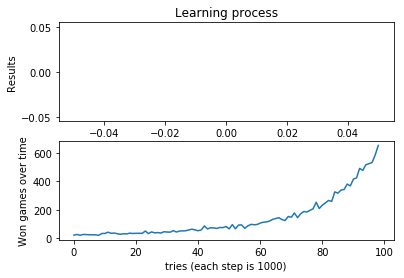

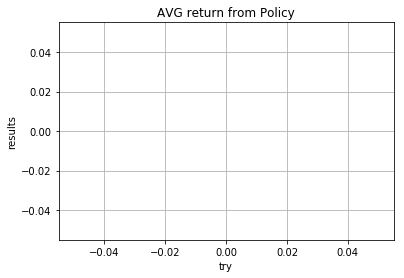

Mean 0.0


In [43]:
x =[]
y = []
number_of_try = 1
number_of_runs = 100000
q_tables = []

for i in range(number_of_try):
    # train
#     W, trace_of_learning, trace_of_won = semi_gradient_sarsa_learning_train(env=env, number_of_runs=number_of_runs, alfa=0.1, gama=0.99,
#                                                       use_e_greedy_policy_decay=True, use_trace_of_learning=True)
    
#     result = evaluate_nn_policy(env, W, 100)
#     q_table = W

    
    W, trace_of_learning, trace_of_won = vf_tf_sarsa_train(env, number_of_runs=number_of_runs, gama=0.99,
                                                                use_e_greedy_policy_decay=True)
    
#     W, trace_of_learning, trace_of_won = vf_tf_monte_carlo_train(env, number_of_runs=number_of_runs, gama=0.99,
#                                                                 use_e_greedy_policy_decay=True)
    
#     result = evaluate_nn_policy(env, W, 100)
#     q_table = W
    result = 0
    q_table = []
    
#     q_table, trace_of_learning, trace_of_won = sarsa_train(env=env, number_of_runs=number_of_runs, alfa=0.1, gama=0.99,
#                                                           use_e_greedy_policy_decay=True, use_trace_of_learning=True)

#     q_table, trace_of_learning, trace_of_won = q_learning_train(env=env, number_of_runs=number_of_runs, alfa=0.1, gama=0.99,
#                                                           use_e_greedy_policy_decay=False, use_trace_of_learning=True)
    sleep(0.1)
    # evaluate
    #result = evaluate_policy(env, q_table, 100)

    # data for charts
    x.append(i)
    y.append(result)
    q_tables.append(q_table)

    # show learning
    plt.subplot(2, 1, 1)
    plt.plot(trace_of_learning)
    plt.title('Learning process')
    plt.ylabel('Results')

    plt.subplot(2, 1, 2)
    plt.plot(trace_of_won)
    plt.xlabel('tries (each step is 1000)')
    plt.ylabel('Won games over time')

    plt.show()

# total analitics    
fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='try', ylabel='results', title='AVG return from Policy')
ax.grid()

#fig.savefig(str(number_of_runs) + '_' + str(number_of_try) + '_plot.png')
plt.show()

print('Mean', np.mean(y))


In [11]:
def get_clean_q_table(q_table):
    clean = np.zeros(q_table.shape)
    for state in range(q_table.shape[0]):
        max_action = np.argmax(q_table[state,:])
        clean[state][max_action] = 1
    return clean

clean_q_table = [] 
total_sum = np.zeros((16,4))
for q_table in q_tables:
    clean_table = get_clean_q_table(q_table)
    clean_q_table.append(clean_table)
    total_sum = np.add(total_sum, clean_table)
    
    
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for n in range(number_of_try):
#     xs = np.arange(16*4)
#     ys = clean_q_table[n].flatten()
#     ax.bar(xs, ys, zs=n, zdir='y')
# ax.set_xlabel('state-action')
# ax.set_ylabel('tries')
# ax.set_zlabel('value: 0 or 1')
# plt.show()

print(total_sum/number_of_try)


AttributeError: 'list' object has no attribute 'shape'